## Load patents data

In [1]:
## Inputs
import dill as pickle
from datetime import datetime
from collections import OrderedDict
import time
with open(r"C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\00 Python data\03 Cleaned patents\all_patents.pkl", 'rb') as f:
    patents = pickle.load(f)
import matplotlib.pyplot as plt
import numpy as np


### Checks

In [ ]:
citedby = [patent for patent in patents if patent.citedby_patents is not None]
print(len(citedby))


for patent in patents:
    if patent.citedby_patents is None:
        assert patent.forward_citations ==0 or patent.forward_citations is None, f"No citations, but forward citations: {patent.forward_citations}"

    if patent.forward_citations is None or patent.forward_citations == 0:
        assert patent.citedby_patents is None, f"Forward citations, but no citations: {patent.citedby_patents}"
        


0 patents with no closest patent
531 patents processed with citations
[0.5796545105566219, 0.7911877394636015, 0.5095057034220533, 0.6015180265654649, 0.504708097928437, 0.6045197740112994, 0.5612052730696798, 0.5819209039548022, 0.504708097928437, 0.4030131826741996, 0.519774011299435]
[0.7792706333973128, 1.3874045801526718, 0.9637404580152672, 1.034351145038168, 0.7796610169491526, 1.0659133709981168, 1.103578154425612, 1.0979284369114877, 0.9227871939736346, 0.783427495291902, 1.0621468926553672]
{-5: 521, -4: 522, -3: 526, -2: 527, -1: 531, 0: 531, 1: 531, 2: 531, 3: 531, 4: 531, 5: 531}
{-5: 521, -4: 524, -3: 524, -2: 524, -1: 531, 0: 531, 1: 531, 2: 531, 3: 531, 4: 531, 5: 531}


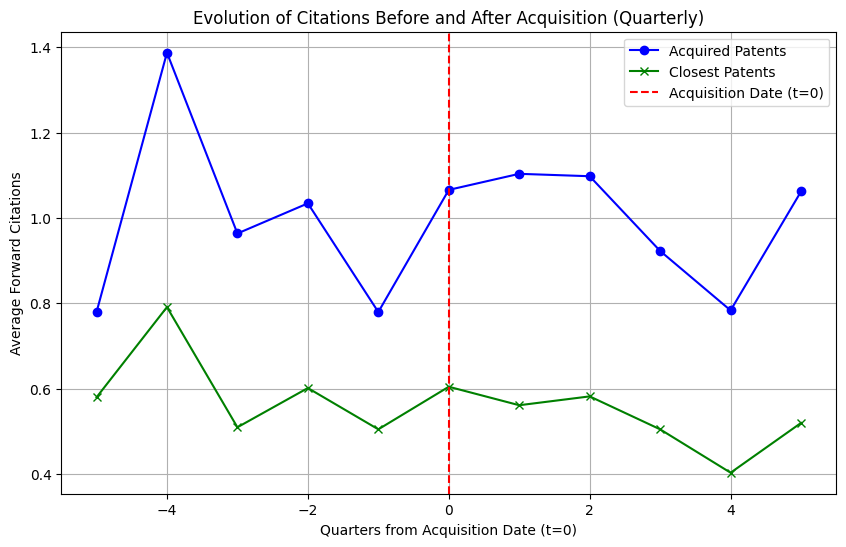

{'Nuance Communications, Inc.'}

In [48]:
import random
list_patents = [p for p in patents if p.assignee_organization == 'Nuance Communications, Inc.' and p.forward_citations > -10]

plot_citation_evolution_adjustable(list_patents, upper_lower_bound=5, implied_days=91, threshold=15, cs_threshold=0, citation_threshold=5)

### Function to plot evolution of citations

In [35]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


def plot_citation_evolution_adjustable(patents, upper_lower_bound=5, implied_days=365, threshold=365, cs_threshold = 0.8, citation_threshold = 1):
    no_closest_patent_counter = 0
    no_cited_patent_counter = 0
    patents_with_citation = 0

    assignees = set()

    # Define the time range dynamically
    time_range = (-upper_lower_bound, upper_lower_bound)
    
    # Initialize dictionaries to store cumulative citation counts and patent counts per quarter
    patent_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
    patent_count_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
    closest_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
    closest_count_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}

    #print("Processing", len(patents), "patents")
    for i, patent in enumerate(patents):

        # Skip if it has less citation than threshold
        if patent.forward_citations is None or patent.forward_citations < citation_threshold: continue
        if patent.cosine_similarity_with_closest_patent is None: continue
        if patent.cosine_similarity_with_closest_patent < cs_threshold:
            continue
        #print(f"Processing patent {i + 1} of {len(patents)}")  # Print progress
        date_acquired = patent.date_acquired
        
        # Ensure each patent's closest patent has citations, else skip
        if patent.closest_patent is None:
            no_closest_patent_counter += 1
            continue

        if patent.citedby_patents is None:
            continue

        # Calculate time bounds around acquisition date
        time_to_acquisition_patent = (patent.date_granted - date_acquired).days // implied_days
        time_to_acquisition_closest = (patent.closest_patent.date_granted - date_acquired).days // implied_days

        # Skip patents without balanced panel (1 year of data before acquisition)
        if time_to_acquisition_patent > -threshold // implied_days or time_to_acquisition_closest > -threshold // implied_days:
            continue
        
        assignees.add(patent.assignee_organization)
        for key, value in patent_count_by_time.items():
            if key >= time_to_acquisition_patent:
                patent_count_by_time[key] += 1

        for key, value in closest_count_by_time.items():
            if key >= time_to_acquisition_closest:
                closest_count_by_time[key] += 1

        # Process citation data for each patent and its closest patent within time bounds
        for cited_patent in patent.citedby_patents:
            t_patent = (cited_patent.date_granted - date_acquired).days // implied_days
            if time_range[0] <= t_patent <= time_range[1]:
                patent_citations_by_time[t_patent] += 1  # Increment citation count for time point
                #patent_count_by_time[t_patent] += 1  # Track patents with citations for averaging

        for cited_patent in patent.closest_patent.citedby_patents:
            t_closest = (cited_patent.date_granted - date_acquired).days // implied_days
            if time_range[0] <= t_closest <= time_range[1]:
                closest_citations_by_time[t_closest] += 1  # Increment citation count for closest patent
                #closest_count_by_time[t_closest] += 1

        patents_with_citation += 1

    print(f"{no_closest_patent_counter} patents with no closest patent")
    print(f"{patents_with_citation} patents processed with citations")

    # Calculate average citations per quarter for acquired and closest patents
    avg_patent_citations = [
        patent_citations_by_time[t] / patent_count_by_time[t] if patent_count_by_time[t] > 0 else 0
        for t in range(time_range[0], time_range[1] + 1)
    ]
    avg_closest_citations = [
        closest_citations_by_time[t] / closest_count_by_time[t] if closest_count_by_time[t] > 0 else 0
        for t in range(time_range[0], time_range[1] + 1)
    ]

    print(avg_closest_citations)
    print(avg_patent_citations)
    print(closest_count_by_time)
    print(patent_count_by_time)
    # Plotting results
    time_points = list(range(time_range[0], time_range[1] + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, avg_patent_citations, label='Acquired Patents', marker='o', color='blue')
    plt.plot(time_points, avg_closest_citations, label='Closest Patents', marker='x', color='green')
    
    # Center line at acquisition date (t=0)
    plt.axvline(x=0, color='red', linestyle='--', label='Acquisition Date (t=0)')
    plt.title("Evolution of Citations Before and After Acquisition (Quarterly)")
    plt.xlabel("Quarters from Acquisition Date (t=0)")
    plt.ylabel("Average Forward Citations")
    plt.legend()
    plt.grid(True)
    plt.show()

    return assignees


## PLot - fixed center date

In [ ]:

center_date=datetime(2016, 12, 7)
no_closest_patent_counter = 0
no_cited_patent_counter = 0
patents_with_citation = 0

upper_lower_bound = 8
implied_days = 365
threshold = 365
# Initialize dictionaries to hold citation counts for each time point (quarters)

time_range=(-upper_lower_bound, upper_lower_bound)
patent_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
patent_count_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
closest_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
closest_count_by_time =  {t: 0 for t in range(time_range[0], time_range[1] + 1)}

print("there are", len(patents), "patents")
for patent in patents:
    if patent.cosine_similarity_with_closest_patent is not None:
        if patent.cosine_similarity_with_closest_patent < 0.6:
            continue
    #if patent.forward_citations  == 0 or not patent.forward_citations or patent.closest_patent.forward_citations == 0 or not patent.closest_patent.forward_citations :
       # no_cited_patent_counter += 1
        #continue
    if (patent.date_granted - center_date).days > -threshold or (patent.closest_patent.date_granted - center_date).days > -threshold:
        #print("BEFORE THE ANALYSIS Period")
        continue
    #if -(patent.date_granted - center_date).days < upper_lower_bound * implied_days:
      # print("Too close to the acquistion")
        #continue
    if patent.closest_patent is None:
        print('None closes patent')
        no_closest_patent_counter +=1
        continue

    #print("Closest patent assignee is: ", patent.closest_patent.assignee_organization)
    # Check if the patent has any citedby_patents
    if patent.citedby_patents:
        for cited_patent in patent.citedby_patents:
            #print(cited_patent.date_granted)
            # Calculate time difference (in quarters) from the center date
            t_patent = (cited_patent.date_granted - center_date).days // implied_days  # Approx. 91 days in a quarter
            #print(t_patent)
            if time_range[0] <= t_patent <= time_range[1]:
                patent_citations_by_time[t_patent] += 1  # Add 1 citation for this quarter
    time_to_acquisition = (patent.date_granted - center_date).days // implied_days
    
    for key, value in patent_count_by_time.items():
        if key >= time_to_acquisition:
            patent_count_by_time[key] += 1
    # Check if the closest patent exists and has any citedby_patents
    if patent.closest_patent and patent.closest_patent.citedby_patents:
        for cited_patent in patent.closest_patent.citedby_patents:
            t_closest = (cited_patent.date_granted - center_date).days // implied_days  # Time difference in quarters
            if time_range[0] <= t_closest <= time_range[1]:
                closest_citations_by_time[t_closest] += 1 # Add 1 citation for this quarter

    time_to_acquisition = (patent.closest_patent.date_granted - center_date).days // implied_days
    
    for key, value in closest_count_by_time.items():
        if key >= time_to_acquisition:
            closest_count_by_time[key] += 1

    patents_with_citation += 1

print(f"There are {no_closest_patent_counter} patents with no closest patent")
print(f"patents with no citation: {no_cited_patent_counter}")   
print(f"paetnts with citation : {patents_with_citation}")

print(patent_citations_by_time)
print(closest_citations_by_time)
print(patent_count_by_time)
print(closest_count_by_time)

# Calculate average citations for each time point (quarter)
avg_patent_citations = [patent_citations_by_time[t]/patent_count_by_time[t] for t in range(time_range[0], time_range[1] + 1)]
avg_closest_citations = [closest_citations_by_time[t]/closest_count_by_time[t] for t in range(time_range[0], time_range[1] + 1)]




# Create the x-axis (time points in quarters)
time_points = list(range(time_range[0], time_range[1] + 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_patent_citations, label='Acquired Patents', marker='o', color='blue')
plt.plot(time_points, avg_closest_citations, label='Closest Patents', marker='x', color='green')

# Highlight t=0 (acquisition date)
plt.axvline(x=0, color='red', linestyle='--', label='Acquisition Date (t=0)')

plt.title("Evolution of Total Citations Before and After Acquisition (Quarterly)")
plt.xlabel("Quarters from Acquisition (t=0)")
plt.ylabel("Total Forward Citations")
plt.xticks(np.arange(time_range[0], time_range[1] + 1), labels=[f"{i}" for i in range(time_range[0], time_range[1] + 1)])
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    if patent.abstract == patent.closest_patent.abstract:
        continue
    if patent.date_acquired is not None:# and patent.cosine_similarity_with_closest_patent < 0.999 :
        cosine_similarities.append(patent.date_acquired)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

## Preliminary estimates

In [3]:
df = patents_to_quarterly_df(patents)

In [31]:
import stata_setup
from pystata import stata
stata_setup.config(path = r"C:\Program Files\Stata18" , edition = 'mp')

stata.pdataframe_to_data(df, force=True)

In [41]:


stata.run("destring matched_pair_id patent_id, replace")
stata.run("xtset patent_id quarters_to_acquired")

matched_pair_id already numeric; no replace


patent_id: all characters numeric; replaced as long


SystemError: repeated time values within panel
r(451);


In [17]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np




In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
def patents_to_relative_quarterly_df(patents, quarters_before=16, quarters_after=16, threshold=91, citation_threshold = 5):
    data = []

    for patent in patents:
        acquisition_date = patent.date_acquired
        granted = False
        matched_pair_id = patent.patent_id  # Use the acquired patent's ID as the matched pair identifier

        for quarter in range(-quarters_before, quarters_after + 1):
            start_of_quarter = acquisition_date + timedelta(days=quarter * 91)
            end_of_quarter = start_of_quarter + timedelta(days=91)

            if end_of_quarter < patent.date_granted:
                continue
            if patent.date_granted > acquisition_date - timedelta(days=threshold):
                continue

            forward_citations_in_quarter = sum(
                1 for c in patent.citedby_patents
                if start_of_quarter <= c.date_granted < end_of_quarter
            ) if patent.citedby_patents else 0

            if not granted and (patent.date_granted <= start_of_quarter or start_of_quarter <= patent.date_granted <= end_of_quarter):
                granted = True

            ## Skip if less than threshold citations
            if patent.forward_citations < citation_threshold:
                continue

            # Determine treatment status based on acquisition timing
            treatment_status = 1 if start_of_quarter >= acquisition_date else 0

            # Data for acquired patent
            acquired_row = {
                'matched_pair_id': matched_pair_id,
                'patent_id': patent.patent_id,
                'quarter_date': start_of_quarter,
                'quarters_to_acquired_date': quarter,
                'treatment': treatment_status,
                'granted': granted,
                'grant_date': patent.date_granted,
                'acquired_date': acquisition_date,
                #'abstract': patent.abstract,
                'assignee_organization': patent.assignee_organization,
                'assignee_country': patent.assignee_country,
                'forward_citations': forward_citations_in_quarter,
                'cosine_similarity_with_closest_patent': patent.cosine_similarity_with_closest_patent,
                'euclidean_distance_to_closest_patent': patent.euclidean_distance_to_closest_patent
            }

            data.append(acquired_row)

            # Data for closest patent (control)
            if patent.closest_patent:
                closest_forward_citations_in_quarter = sum(
                    1 for c in patent.closest_patent.citedby_patents
                    if start_of_quarter <= c.date_granted < end_of_quarter
                ) if patent.closest_patent.citedby_patents else 0

                granted_closest = start_of_quarter < patent.closest_patent.date_granted < end_of_quarter

                control_row = {
                    'matched_pair_id': matched_pair_id,
                    'patent_id': patent.closest_patent.patent_id,
                    'quarter_date': start_of_quarter,
                    'quarters_to_acquired_date': quarter,
                    'treatment': 0,
                    'granted': granted_closest,
                    'grant_date': patent.closest_patent.date_granted,
                    'acquired_date': acquisition_date,  # Use the same acquisition date for the pair
                   # 'abstract': patent.closest_patent.abstract,
                    'assignee_organization': patent.closest_patent.assignee_organization,
                    'assignee_country': patent.closest_patent.assignee_country,
                    'forward_citations': closest_forward_citations_in_quarter,
                    'cosine_similarity_with_closest_patent': patent.cosine_similarity_with_closest_patent,
                    'euclidean_distance_to_closest_patent':  patent.euclidean_distance_to_closest_patent
                }

                data.append(control_row)

    df = pd.DataFrame(data)
    return df




def patents_to_quarterly_df(patents):
    data = []

    current_date = datetime.now()

    for patent in patents:
        # Calculate the number of quarters from the grant date to the current date
        quarters_since_grant = ((current_date.year - patent.date_granted.year) * 12 +
                                (current_date.month - patent.date_granted.month)) // 3
        
        for quarter in range(quarters_since_grant + 1):  # +1 to include the current quarter
            start_of_quarter = patent.date_granted + timedelta(days=quarter * 91)  # Start date of the quarter
            end_of_quarter = start_of_quarter + timedelta(days=91)  # Approximate end date of the quarter
            
            # Count forward citations specifically within this quarter for the patent
            forward_citations_in_quarter = sum(
                1 for c in patent.citedby_patents 
                if start_of_quarter <= c.date_granted < end_of_quarter
            ) if patent.citedby_patents else 0

            # Collect patent data for the row
            row = {
                'patent_id': patent.patent_id,
                'quarter_date': start_of_quarter,
                'abstract': patent.abstract,
                'assignee_organization': patent.assignee_organization,
                'assignee_country': patent.assignee_country,
                'forward_citations': forward_citations_in_quarter,
                'cosine_similarity_with_closest_patent': patent.cosine_similarity_with_closest_patent,
                'euclidean_distance_to_closest_patent': patent.euclidean_distance_to_closest_patent
            }

            # If closest patent data is available, add its citations within the quarter
            if patent.closest_patent:
                closest_forward_citations_in_quarter = sum(
                    1 for c in patent.closest_patent.citedby_patents 
                    if start_of_quarter <= c.date_granted < end_of_quarter
                ) if patent.closest_patent.citedby_patents else 0

                row.update({
                    'closest_patent_id': patent.closest_patent.patent_id,
                    'closest_patent_abstract': patent.closest_patent.abstract,
                    'closest_assignee_organization': patent.closest_patent.assignee_organization,
                    'closest_assignee_country': patent.closest_patent.assignee_country,
                    'closest_forward_citations': closest_forward_citations_in_quarter,
                })
            else:
                # Fill in None for closest patent data if not available
                row.update({
                    'closest_patent_id': None,
                    'closest_patent_abstract': None,
                    'closest_assignee_organization': None,
                    'closest_assignee_country': None,
                    'closest_forward_citations': None,
                })

            data.append(row)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)
    
    return df

# Example usage:
# df = patents_to_relative_quarterly_df(list_of_patent_objects)
# df.to_excel("patents_relative_quarterly_data.xlsx", index=False)


## Matching estimates

In [2]:
for patent in patents:
    print(patent.assignee_organization)#, matching_estimate(patent, 5, 5))

Stac Electronics, Inc.
Stac Electronics, Inc.
UUNet Technologies, Inc.
UUNet Technologies, Inc.
Individual, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.
Wang Laboratories, Inc.

In [33]:
estimates = []

#for year in range(1990, 2024):
list_patents = [p for p in patents if p.assignee_organization == 'Nuance Communications, Inc.' and p.forward_citations >= 0]
for patent in list_patents:

    #if patent.date_acquired.year > 2021: continue
    
    # Get matching estimate
    if matching_estimate(patent, 16, 16) is not None:
        #if matching_estimate(patent, 16, 16) > 

        estimates.append(matching_estimate(patent, 3, 5))

print(f"Average matching estimate: {np.mean(estimates):.3f}, out of {len(list_patents)} patents, for year {year}")

Average matching estimate: 0.127, out of 1407 patents, for year 2023


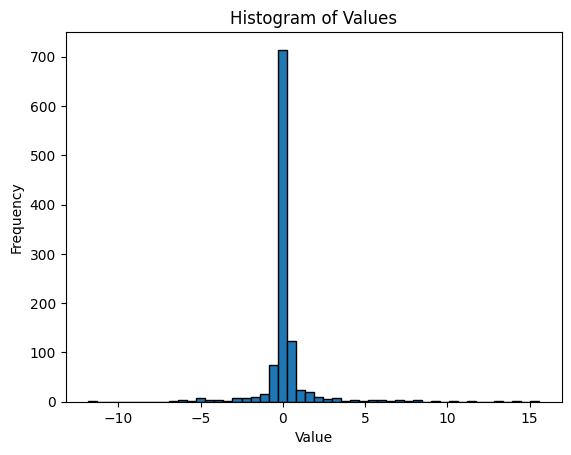

In [30]:
clean = [p for p in estimates if p is not None]

import matplotlib.pyplot as plt

# Convert the min and max to integers
min_val = int(min(clean))
max_val = int(max(clean))

# Create histogram
plt.hist(clean, edgecolor='black', bins = 50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()


In [77]:
import pandas as pd

df = pd.DataFrame(clean, columns=['Matching Estimate'])
df.to_excel("matching_estimates.xlsx", index=False)

In [6]:
# Function to get matching estimator for any given patent:
from datetime import datetime, timedelta
def matching_estimate(patent, quarters_before, quarters_after):
    ## Skip the patent if it does not have a closest patent
    if not patent.closest_patent:
        #print("Patent does not have a closest patent, returning None!")
        return None
    
    # Get dates
    acquisition_date = patent.date_acquired
    grant_date = patent.date_granted
    start_date = grant_date - timedelta(days=quarters_before * 91)
    end_date = grant_date + timedelta(days=quarters_after * 91)

    if grant_date > acquisition_date:
        #print("Grant date is after acquisition date, returning None!")
        return None
    
    # Initialize the list of forward citations for the treatment/control group
    treatment_forward_citations = {}
    control_forward_citations = {}

    # Time from grant date to acquisition date
    if start_date< grant_date < acquisition_date:
       # print("Grant date is after the threshold but before the acquisition date, adjusting quarters before!")
        time_to_acquisition = (acquisition_date - grant_date).days
        quarters_before = np.ceil(time_to_acquisition/91)

    # Count forward citations before the acquisition date
    forward_citations_before = sum(
        1 for c in patent.citedby_patents 
        if start_date <= c.date_granted < acquisition_date
    ) if patent.citedby_patents else 0
    
    treatment_forward_citations['before'] = forward_citations_before/quarters_before

    # Count forward citations after the acquisition date
    forward_citations_after = sum(
        1 for c in patent.citedby_patents 
        if acquisition_date <= c.date_granted < end_date
    ) if patent.citedby_patents else 0

    treatment_forward_citations['after'] = forward_citations_after/quarters_after

    # Count forward citations before the acquisition date for the closest patent
    closest_forward_citations_before = sum(
        1 for c in patent.closest_patent.citedby_patents 
        if start_date <= c.date_granted < acquisition_date
    ) if patent.closest_patent.citedby_patents else 0
    
    control_forward_citations['before'] = closest_forward_citations_before/quarters_before

    # Count forward citations after the acquisition date for the closest patent
    closest_forward_citations_after = sum(
        1 for c in patent.closest_patent.citedby_patents 
        if acquisition_date <= c.date_granted < end_date
    ) if patent.closest_patent.citedby_patents else 0
    
    control_forward_citations['after'] = closest_forward_citations_after/quarters_after
    
    # Calculate the difference in forward citations for the treatment and control groups
    diff_after = treatment_forward_citations['after'] - control_forward_citations['after']
    diff_before = treatment_forward_citations['before'] - control_forward_citations['before']

    matching_estimate = diff_after - diff_before

    #Print the results
    #print(f"Patent ID: {patent.patent_id}")
    #print(f"Quarters before acquisition date: {quarters_before}")
    #print(f"Quarters after acquisition date: {quarters_after}")
    #print(f"Forward citations before acquisition date: {forward_citations_before}")
    #print(f"Forward citations after acquisition date: {forward_citations_after}")
    #print(f"Closest patent forward citations before acquisition date: {closest_forward_citations_before}")
    #print(f"Closest patent forward citations after acquisition date: {closest_forward_citations_after}")
    #print(f"Matching estimate: {matching_estimate}")

    return matching_estimate


